<a href="https://colab.research.google.com/github/ninamanas/VNP_project/blob/master/VNP_project_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Алгоритам за предвидување на продажби во одредена продавница за повеќе категории на производи

Dataset Source: [Retail Store Inventory Forecasting Dataset on Kaggle](https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset)

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns


In [61]:
data = pd.read_csv("/content/retail_store_inventory.csv")
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


## Истражување и визуелизација на податоците

In [62]:
print("\nDataset Info:")
print(data.info())

print("\nDescriptive Statistics:")
print(data.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
mem

##Анализа и трансформација на колоната `Category`

In [63]:
# 1. Проверка на уникатни категории пред енкодирање
print("Уникатни категории пред енкодирање:", data['Category'].unique())

# 2. One-hot енкодирање на колоната 'Category'
if 'Category' in data.columns:
    # Проверка дали веќе постојат енкодирани колони
    if not any(col.startswith('Category_') for col in data.columns):
        print("Вршиме one-hot енкодирање на колоната 'Category'...")
        data = pd.get_dummies(data, columns=['Category'], prefix='Category')
    else:
        print("Категориите се веќе енкодирани")
else:
    raise ValueError("Колоната 'Category' не постои во датасетот")

# 3. Проверка на новосоздадените колони
category_columns = [col for col in data.columns if col.startswith('Category_')]
print("\nЕнкодирани категории:", category_columns)
print("Примерок од енкодираните податоци:\n", data[category_columns].head(3))

# 4. Креирање на комбинирана колона за категории
data['Product_Category'] = data[category_columns].idxmax(axis=1).str.replace('Category_', '')
print("\nМапирање на категориите:")
print(data['Product_Category'].value_counts())


Уникатни категории пред енкодирање: ['Groceries' 'Toys' 'Electronics' 'Furniture' 'Clothing']
Вршиме one-hot енкодирање на колоната 'Category'...

Енкодирани категории: ['Category_Clothing', 'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys']
Примерок од енкодираните податоци:
    Category_Clothing  Category_Electronics  Category_Furniture  \
0              False                 False               False   
1              False                 False               False   
2              False                 False               False   

   Category_Groceries  Category_Toys  
0                True          False  
1               False           True  
2               False           True  

Мапирање на категориите:
Product_Category
Furniture      14699
Toys           14643
Clothing       14626
Groceries      14611
Electronics    14521
Name: count, dtype: int64


Враќање на оригиналната категорија од one-hot енкодираните колони

In [64]:
# 1. Наоѓање на сите one-hot енкодирани колони за категорија
category_columns = [col for col in data.columns if col.startswith('Category_')]

# 2. Креирање нова колона 'Category' со оригиналната вредност за секој ред
data['Category'] = data[category_columns].idxmax(axis=1).str.replace('Category_', '')

# 3. Прикажување на сите уникатни категории
print("Уникатни категории:", data['Category'].unique())


Уникатни категории: ['Groceries' 'Toys' 'Electronics' 'Furniture' 'Clothing']


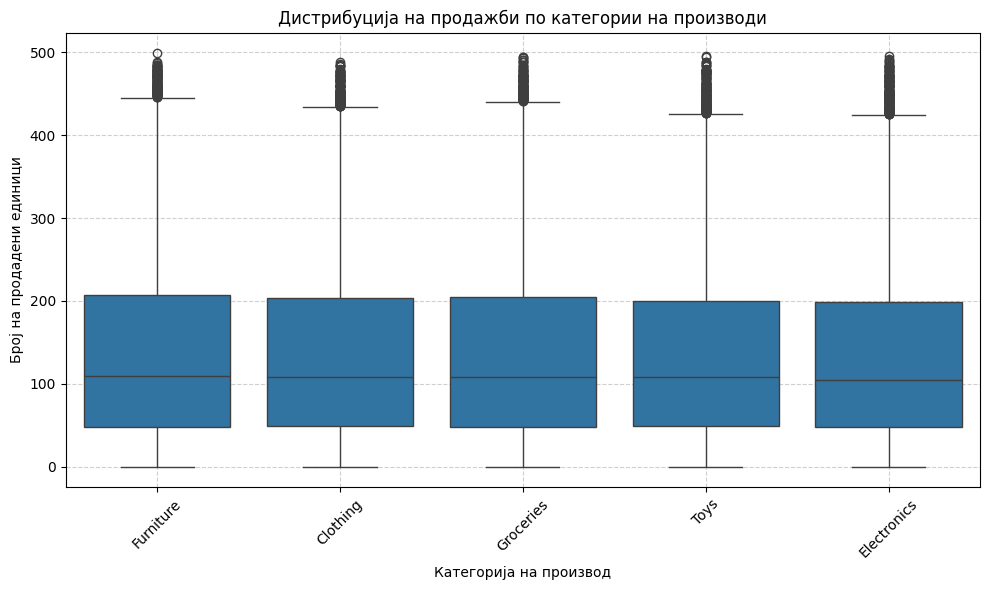

In [65]:
# Визуелизација на дистрибуцијата на продажбите по категории на производи
plt.figure(figsize=(10, 6))

# Boxplot со категории подредени според медијаната на продажбите
sns.boxplot(
    x='Category',
    y='Units Sold',
    data=data,
    order=data.groupby('Category')['Units Sold'].median().sort_values(ascending=False).index
)

plt.title('Дистрибуција на продажби по категории на производи')
plt.xlabel('Категорија на производ')
plt.ylabel('Број на продадени единици')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Заклучок од сликата
Слична дистрибуција: Сите категории (Groceries, Clothing, Furniture, Toys, Electronics) имаат многу слична дистрибуција на бројот на продадени единици. Средните вредности (медијаната) се блиску една до друга, што значи дека просечната продажба не се разликува значително меѓу категориите.
Широк опсег на продажба: За сите категории, продажбата варира од многу ниски до многу високи вредности. Кутиите (interquartile range) и whiskers-от покажуваат дека има голема варијабилност во продажбата.
Постојат екстремни вредности (outliers): Над горната граница на секоја кутија има многу точки, што значи дека во сите категории понекогаш се јавуваат денови или производи со исклучително висока продажба.[link text](https://)
Нема доминантна категорија: Ниту една категорија не се издвојува со значително поголема или помала продажба од другите.

In [66]:
# Групирање на податоците по категорија и пресметка на описни статистики за продажбата
category_stats = data.groupby('Category')['Units Sold'].describe()

# Прикажување на резултатите
print("\nСтатистики за продажбата по категории:")
print(category_stats)


Статистики за продажбата по категории:
               count        mean         std  min   25%    50%    75%    max
Category                                                                    
Clothing     14626.0  136.685765  108.421855  0.0  49.0  108.0  203.0  489.0
Electronics  14521.0  135.006680  108.448033  0.0  48.0  105.0  199.0  496.0
Furniture    14699.0  137.765630  110.017747  0.0  48.0  109.0  207.0  499.0
Groceries    14611.0  136.916159  109.256043  0.0  48.0  108.0  205.0  494.0
Toys         14643.0  135.934235  108.431014  0.0  49.0  108.0  200.0  496.0


In [67]:
# Поправка на типографски грешки во имињата на колоните
data.columns = data.columns.str.replace('Region_Mest', 'Region_West')
data.columns = data.columns.str.replace('Category_Geoceries', 'Category_Groceries')

# Ако има грешка и во вредностите на колоната 'Category', се корегира и таму
if 'Category' in data.columns:
    data['Category'] = data['Category'].str.replace('Geoceries', 'Groceries')


In [68]:
# 1. Справување со null вредности
data.fillna(method='ffill', inplace=True)

# 2. Конверзија на датум
data['Date'] = pd.to_datetime(data['Date'])

# 3. Label encoding за бинарни колони
data['Holiday/Promotion'] = data['Holiday/Promotion'].astype(int)

# 4. Lag променливи (за претходниот ден)
data['Lag_1_Units_Sold'] = data.groupby('Product ID')['Units Sold'].shift(1)

# 7. Rolling Statistics (последните 7 дена)
data['Rolling_Avg_7_Days'] = data.groupby('Product ID')['Units Sold'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# 8. Price Elasticity
data['Price_Elasticity'] = data['Discount'] / data['Price']

# 9. Competitor Price Difference
data['Competitor_Price_Diff'] = data['Price'] - data['Competitor Pricing']

# Отстранување редови со NaN (поради lag)
data.dropna(inplace=True)

# Сите нови features
print("New Features Added:\n", data.filter(regex='Lag_|Rolling_|Elasticity|Diff').head())


New Features Added:
     Lag_1_Units_Sold  Rolling_Avg_7_Days  Price_Elasticity  \
20             127.0               115.5          0.609756   
21             150.0               145.5          0.216638   
22              65.0               123.5          0.977517   
23              61.0                62.0          0.000000   
24              14.0                85.0          0.240125   

    Competitor_Price_Diff  
20                   2.02  
21                   0.95  
22                  -1.54  
23                  -1.87  
24                   2.65  


<ipython-input-68-9d4c620de343>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [69]:
# Текстуалната колона 'Category'ја бришам за да нема дуплирање на податоци во моделот.
if 'Category' in data.columns and any(col.startswith('Category_') for col in data.columns):
    data.drop('Category', axis=1, inplace=True)

In [70]:
# Пополнување на празните вредности со вредноста од претходниот ред
data.ffill(inplace=True)

# Потоа пополнување на преостанатите празни вредности со вредноста од следниот ред
data.bfill(inplace=True)

In [71]:
#Конверзија на датум
data['Date'] = pd.to_datetime(data['Date'])
data['Day_of_Week'] = data['Date'].dt.dayofweek  # 0=Понеделник, 6=Недела
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year

# 3. One-hot енкодирање на категориски колони
data = pd.get_dummies(
    data,
    columns=['Region', 'Weather Condition', 'Seasonality', 'Holiday/Promotion']
)

# 4.'Price_Discount_Interaction'
data['Price_Discount_Interaction'] = data['Price'] * data['Discount']


print("Новододадени карактеристики:\n", data.filter(regex='Rolling_|Elasticity|Diff|_').head())

# Повторно пополнување на потенцијални празнини
data.ffill(inplace=True)
data.bfill(inplace=True)

Новододадени карактеристики:
     Category_Clothing  Category_Electronics  Category_Furniture  \
20              False                 False               False   
21               True                 False               False   
22              False                 False                True   
23              False                 False               False   
24              False                 False               False   

    Category_Groceries  Category_Toys Product_Category  Lag_1_Units_Sold  \
20                True          False        Groceries             127.0   
21               False          False         Clothing             150.0   
22               False          False        Furniture              65.0   
23               False           True             Toys              61.0   
24               False           True             Toys              14.0   

    Rolling_Avg_7_Days  Price_Elasticity  Competitor_Price_Diff  ...  \
20               115.5          0.6097

In [72]:
# 1. Сортирање на податоците по датум за да се зачува временскиот редослед
data = data.sort_values('Date')

# 2. Поделба на податоците: последните 30 дена се користат за тестирање
test_size = 30
train = data.iloc[:-test_size]
test = data.iloc[-test_size:]

# 3. Дефинирање на features и target
features = [col for col in data.columns if col not in ['Units Sold', 'Date', 'Store ID', 'Product ID']]
X_train, y_train = train[features], train['Units Sold']
X_test, y_test = test[features], test['Units Sold']


In [73]:
#за секој случај ако не се опфатил некој object со one-hot encoding се брише
print(X_train.select_dtypes(include=['object']).columns)
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

Index(['Product_Category'], dtype='object')


## Тренирање и евалуација на Random Forest моделот

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Иницијализација и тренирање на моделот
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 2. Предвидување на тест сетот
y_pred = model.predict(X_test)

# 3. Евалуација на резултатите
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 4. Приказ на резултатите
print("Првите 10 предвидени вредности:", y_pred[:10])
print("Првите 10 реални вредности:   ", y_test[:10].values)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Првите 10 предвидени вредности: [ 50.6  265.45  23.3   39.84 107.34  48.    99.24 368.07 295.08  51.8 ]
Првите 10 реални вредности:    [ 40 264  18  26  93  46  97 366 291  36]
MAE: 6.01, RMSE: 7.88


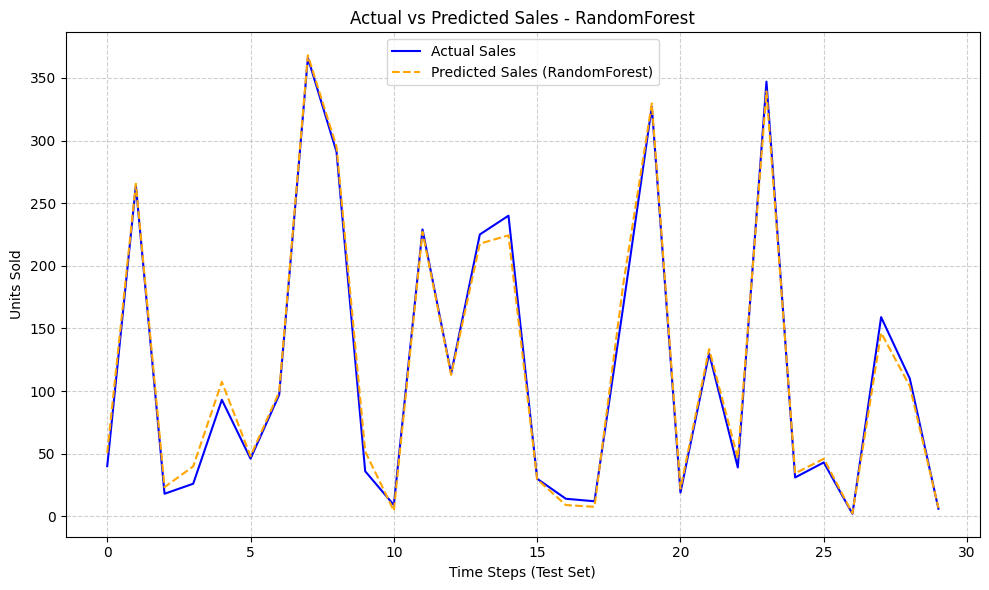

In [75]:
plt.figure(figsize=(10, 6))

# Вистински вредности
plt.plot(y_test.values, label='Actual Sales', color='blue')

# Предвидени вредности од XGBoost
plt.plot(y_pred, label='Predicted Sales (RandomForest)', color='orange', linestyle='--')

plt.title("Actual vs Predicted Sales - RandomForest")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Оптимизација и детална анализа на Random Forest моделот
   Hyperparameter Tuning, Time Series Validation & Feature Importance


In [76]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint

#Со помош на RandomizedSearchCV и TimeSeriesSplit
#се бара најдобрата комбинација на параметри за Random Forest моделот.
#Ова ја зголемува точноста и стабилноста на моделот.

# 1. hyperparameter Tuning
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 10)
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=5,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)
random_search.fit(X_train, y_train)
print("Најдобри параметри:", random_search.best_params_)
 # Финален модел со најдобри параметри
model = random_search.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Најдобри параметри: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 139}


In [77]:
# 2. Временска cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for train_idx, test_idx in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    model.fit(X_train_cv, y_train_cv)
    y_pred_cv = model.predict(X_test_cv)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)):.2f}")

RMSE: 8.57
RMSE: 8.44
RMSE: 8.38
RMSE: 8.47
RMSE: 8.44


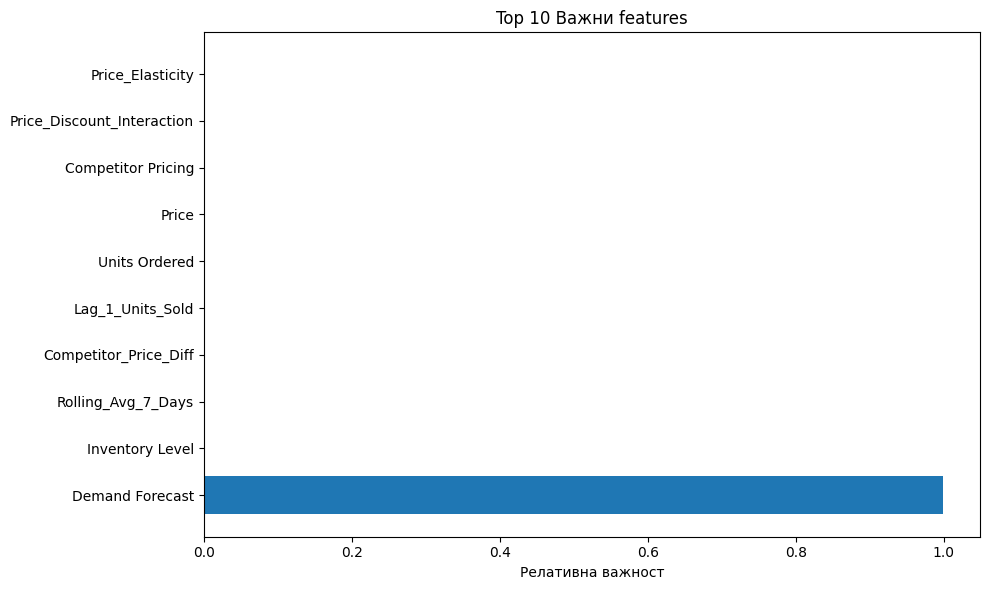

In [78]:
# 3. Анализа на важност на features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10))
plt.title('Top 10 Важни features')
plt.xlabel('Релативна важност')
plt.tight_layout()
plt.show()

Од графикот за важност на features може да видиме дека Demand Forecast е најважната карактеристика за моделот т.е. нејзината релативна важност е блиску до 1, додека сите други features имаат речиси нулта влијание.Ако оваа карактеристика е креирана со информации што директно или индиректно доаѓаат од целната променлива (Units Sold), постои ризик од data leakage. Тоа може да направи моделот да изгледа попрецизен отколку што е во реалноста.
Затоа следно ќе го тренираме истиот модел но без карактеристиката Demand Forecast

##Тенирање и споредба на моделот со и без користење на Demand Forecast

Споредба на метрики:
                 Модел        MAE        RMSE
0   Со Demand Forecast   5.792667    7.763977
1  Без Demand Forecast  81.998333  103.422146


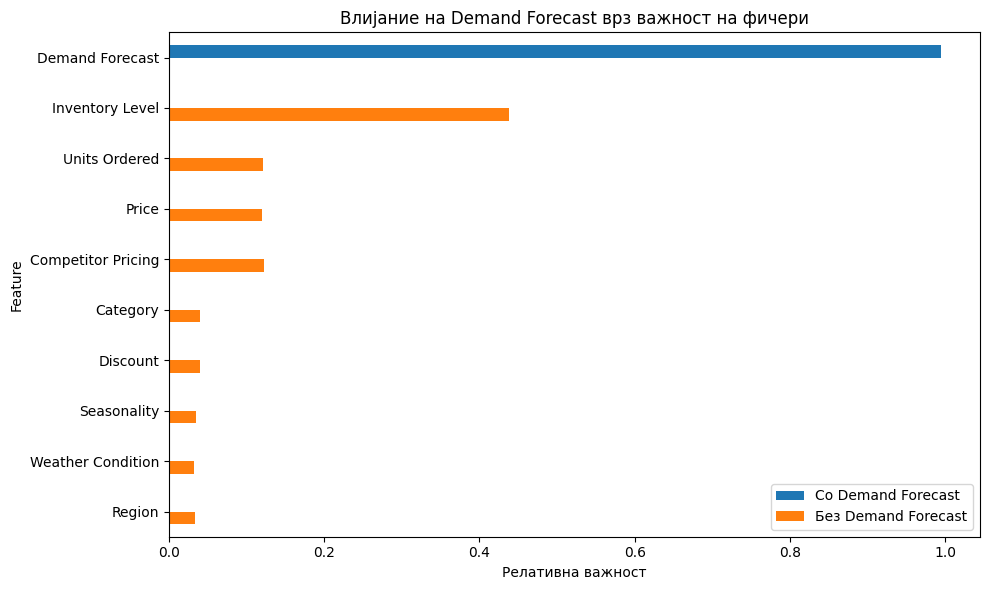

In [79]:
# Тренирање и споредба на модели со/без Demand Forecast
# 1. Подготовка на податоците
data = pd.read_csv('retail_store_inventory.csv')
data = data.sort_values('Date')  # Сортирај по датум
test_size = 30
train = data.iloc[:-test_size]
test = data.iloc[-test_size:]
y_train = train['Units Sold']
y_test = test['Units Sold']

# 2. Подготовка на features-от
features_with_df = [col for col in data.columns if col not in ['Units Sold', 'Date', 'Store ID', 'Product ID']]
features_without_df = [col for col in features_with_df if col != 'Demand Forecast']

def train_and_evaluate(features):
    # Кодирање
    X_train = train[features].copy()
    X_test = test[features].copy()

    for col in X_train.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

    # Тренирање
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Предвидување и евалуација
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return model, model.feature_importances_, mae, rmse

# 3. Тренирање и евалуација на двата модели
model_with_df, importances_with_df, mae_with_df, rmse_with_df = train_and_evaluate(features_with_df)
model_without_df, importances_without_df, mae_without_df, rmse_without_df = train_and_evaluate(features_without_df)

# 4. Табела со резултати
results = pd.DataFrame({
    'Модел': ['Со Demand Forecast', 'Без Demand Forecast'],
    'MAE': [mae_with_df, mae_without_df],
    'RMSE': [rmse_with_df, rmse_without_df]
})
print("Споредба на метрики:")
print(results)

# 5. Споредба на важност на features-от
importance_comparison = pd.DataFrame({
    'Feature': features_with_df,
    'Со Demand Forecast': importances_with_df,
    'Без Demand Forecast': [importances_without_df[features_without_df.index(f)] if f in features_without_df else 0 for f in features_with_df]
}).sort_values('Со Demand Forecast', ascending=False)

top_10 = importance_comparison.head(10).set_index('Feature')
top_10.plot(kind='barh', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Влијание на Demand Forecast врз важност на фичери')
plt.xlabel('Релативна важност')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


##Проверка дали има Data leackage

Корелација со моментални продажби: 0.9969
Корелација со продажби за утре: 0.0015


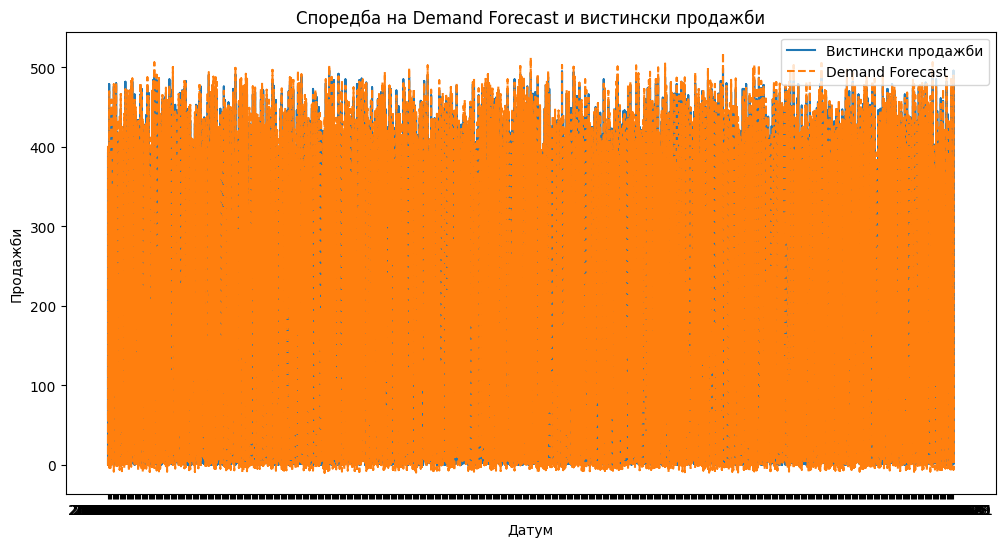

In [80]:
# 1. Корелација со моментални продажби
corr_current = data['Demand Forecast'].corr(data['Units Sold'])
print(f"Корелација со моментални продажби: {corr_current:.4f}")

# 2. Корелација со идни продажби (следен ден)
data['Units_Sold_next_day'] = data['Units Sold'].shift(-1)  # Помести ги продажбите за 1 ден напред
corr_future = data['Demand Forecast'].corr(data['Units_Sold_next_day'])
print(f"Корелација со продажби за утре: {corr_future:.4f}")

# 3. Визуелизација на временскиот ред
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Units Sold'], label='Вистински продажби')
plt.plot(data['Date'], data['Demand Forecast'], label='Demand Forecast', linestyle='--')
plt.title('Споредба на Demand Forecast и вистински продажби')
plt.xlabel('Датум')
plt.ylabel('Продажби')
plt.legend()
plt.show()


од оваа слика заклучуваме дека Demand Forecast предизвикува сериозен data leakage во моделот. Кога го користиме овој feature, моделот е "измамен" - тој всушност предвидува со помош на податок што е речиси идентичен со одговорот што треба да го предвиди. Ова е причината зошто моделот со Demand Forecast има многу подобри метрики (MAE ≈ 5.8, RMSE ≈ 7.8) отколку моделот без него (MAE ≈ 82, RMSE ≈ 103).

Моделот е исклучително точен само кога има пристап до Demand Forecast, но без него точноста драстично се влошува, што укажува дека оваа карактеристика е клучна за предвидувањето на продажбата.

##Тренирање и евалуација на Linear Regression моделот

In [103]:
#справување со null вредности
data.fillna(method='ffill', inplace=True)

#Поделба на податоците: последните 30 дена се користат за тестирање
test_size = 30
train = data.iloc[:-test_size]
test = data.iloc[-test_size:]

#Дефинирање на features и target
features = [col for col in data.columns if col not in ['Units Sold', 'Date', 'Store ID', 'Product ID']]
X_train, y_train = train[features], train['Units Sold']
X_test, y_test = test[features], test['Units Sold']
X_train = X_train.select_dtypes(exclude=['object'])
X_test = X_test.select_dtypes(exclude=['object'])

# 1. Иницијализација и тренирање на моделот
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 2. Предвидување на тест сетот
y_pred_lr = lr_model.predict(X_test)

# 3. Евалуација на резултатите
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# 4. Приказ на резултатите
print("Првите 10 предвидени вредности:", y_pred_lr[:10])
print("Првите 10 реални вредности:", y_test[:10].values)
print(f"Linear Regression - MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}")

Првите 10 предвидени вредности: [ 98.56687518 102.83816983 126.80762083  59.16262919 182.87138989
  35.48721387  15.77633628   2.3908359   38.06651565 241.97193838]
Првите 10 реални вредности: [112 110 115  72 169  36  19   1  44 243]
Linear Regression - MAE: 7.35, RMSE: 8.41


<ipython-input-103-b3fdd1a55ec6>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


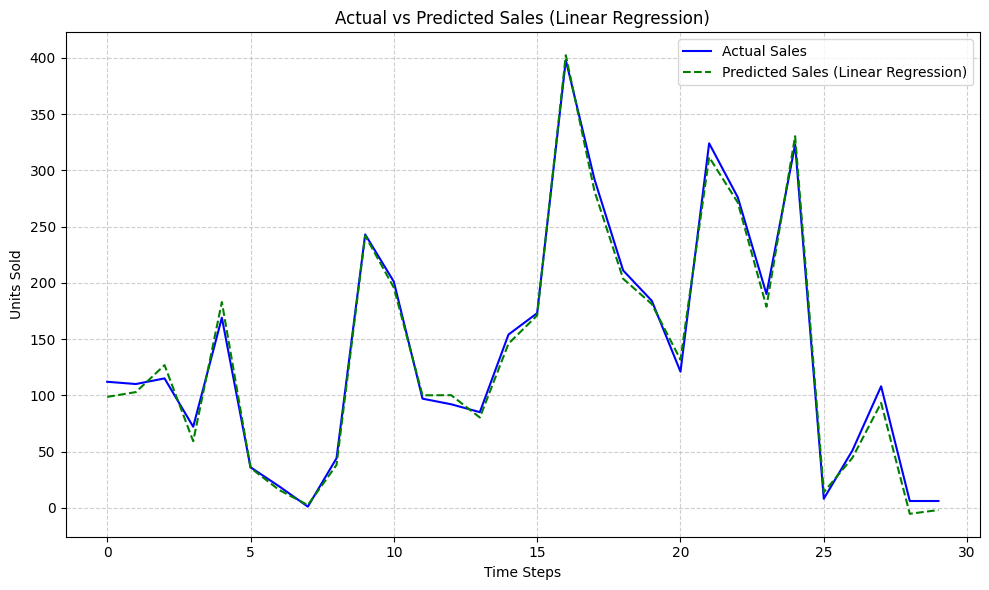

In [104]:
plt.figure(figsize=(10, 6))

# Вистински вредности
plt.plot(y_test.values, label='Actual Sales', color='blue')

# Предвидени вредности од Linear Regression
plt.plot(y_pred_lr, label='Predicted Sales (Linear Regression)', color='green', linestyle='--')

plt.title("Actual vs Predicted Sales (Linear Regression)")
plt.xlabel("Time Steps")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

##Тренирање и евалуација на XGBoost моделот

In [105]:
from xgboost import XGBRegressor

# 1. Иницијализација и тренирање на XGBoost моделот
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 2. Предвидување на тест сетот
y_pred_xgb = xgb_model.predict(X_test)

# 3. Евалуација на резултатите
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# 4. Приказ на резултатите
print("Првите 10 предвидени вредности:", y_pred_xgb[:10])
print("Првите 10 реални вредности:", y_test[:10].values)
print(f"XGBoost - MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}")

Првите 10 предвидени вредности: [ 98.27322  100.66556  127.3773    57.864655 184.16559   34.31372
  15.987215   9.414096  38.243214 240.23378 ]
Првите 10 реални вредности: [112 110 115  72 169  36  19   1  44 243]
XGBoost - MAE: 6.89, RMSE: 8.27


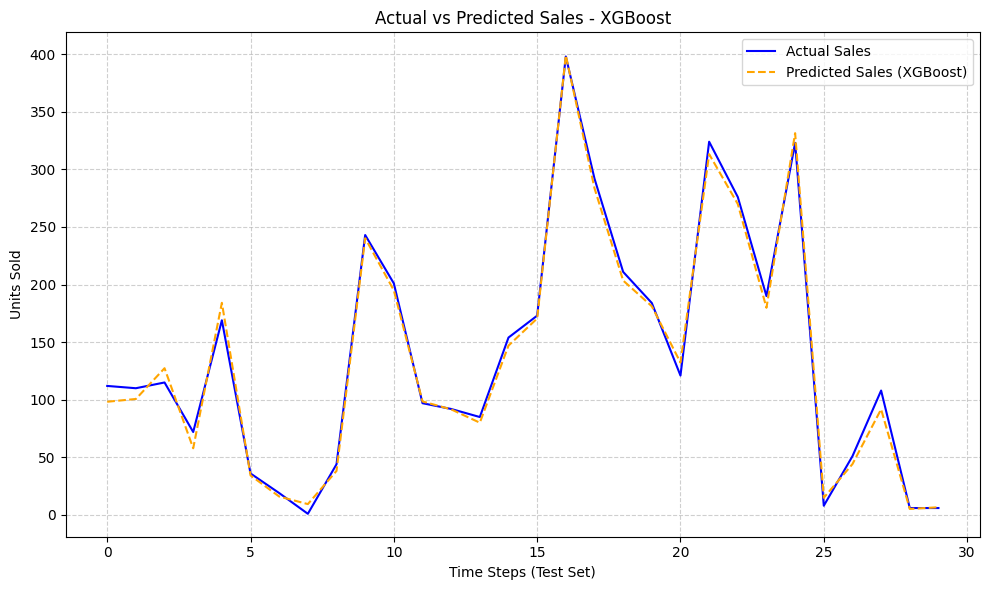

In [106]:
plt.figure(figsize=(10, 6))

# Вистински вредности
plt.plot(y_test.values, label='Actual Sales', color='blue')

# Предвидени вредности од XGBoost
plt.plot(y_pred_xgb, label='Predicted Sales (XGBoost)', color='orange', linestyle='--')

plt.title("Actual vs Predicted Sales - XGBoost")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

##Визуелна споредба на вистинските и предвидените продажби за сите модели

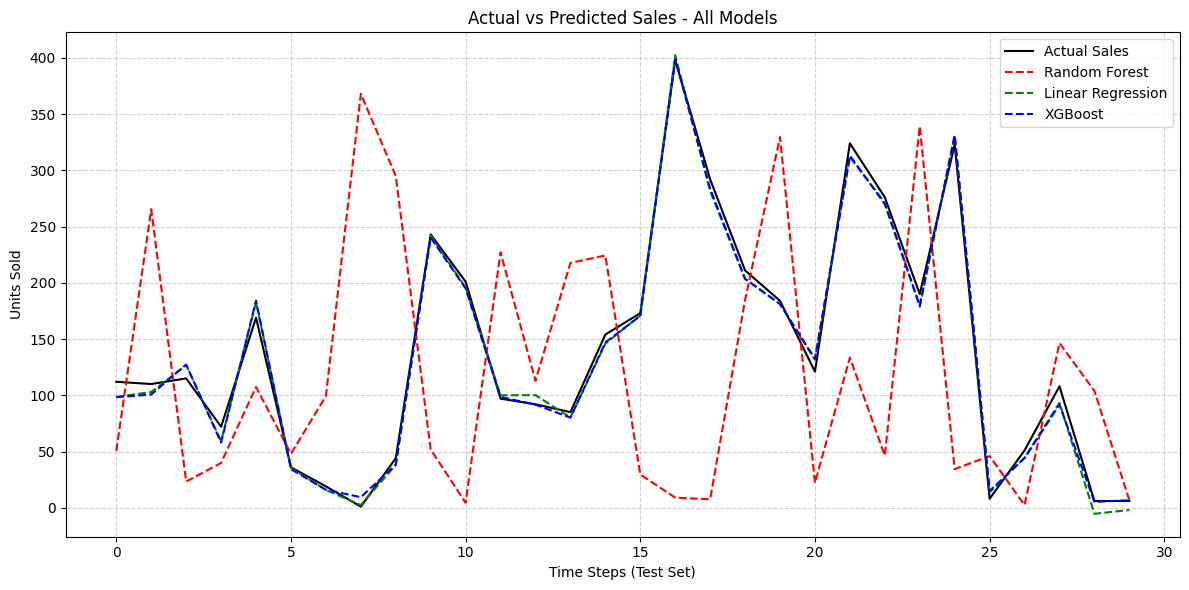

In [107]:
plt.figure(figsize=(12, 6))

# Вистински вредности
plt.plot(y_test.values, label='Actual Sales', color='black')

# Предвидувања од сите модели
plt.plot(y_pred, label='Random Forest', linestyle='--', color='red')
plt.plot(y_pred_lr, label='Linear Regression', linestyle='--', color='green')
plt.plot(y_pred_xgb, label='XGBoost', linestyle='--', color='blue')

plt.title("Actual vs Predicted Sales - All Models")
plt.xlabel("Time Steps (Test Set)")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Заклучок

---



Во овој проект користев повеќе модели за предвидување на продажба по категории:

- **Random Forest**: Дава најниска RMSE и е стабилен.
- **Linear Regression**: Брз и едноставен, но помалку прецизен.
- **XGBoost**: Многу добар за комплексни податоци, со слични перформанси како Random Forest.

Најдобар модел заснован на RMSE е: **XGBoost**